In [266]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
import time
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import statsmodels.api as sm


In [267]:
d = pd.read_csv('data/cleaned_data_together.csv')
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df
df = df_cleaner(d)
df = df.set_index(pd.DatetimeIndex(df.DateTime))

df.head(2)

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY
DateTime,,,,,,,,
2010-01-01,2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1
2010-01-02,2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2


In [268]:
df['MOY'] =df['DateTime']
def moy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return date.month
df['MOY'] = df['MOY'].apply(lambda x : moy(x))

df['WOY'] =df['DateTime']
def woy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return int(date.strftime("%V"))
df['WOY'] = df['WOY'].apply(lambda x : woy(x))
df.pop('DateTime')
df.head(2)

,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,MOY,WOY
DateTime,,,,,,,,,
2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1,1,53
2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2,1,53


In [269]:
df.head(2)

,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,MOY,WOY
DateTime,,,,,,,,,
2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1,1,53
2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2,1,53


In [270]:
df['consump_trend'] = sm.tsa.seasonal_decompose(df['Consumption MMCF'], freq= 365).trend.fillna(method= 'backfill').fillna(method= 'ffill')

In [271]:
df.head(2)

,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,MOY,WOY,consump_trend
DateTime,,,,,,,,,,
2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1,1,53,1.974475e+06
2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2,1,53,1.974475e+06


In [272]:
doy = df.pop('DOY')
dfw =df.resample('W').mean()
dfw.head(2)

,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,MOY,WOY,consump_trend
DateTime,,,,,,,,,
2010-01-03,5.820000,24.603433,2197157.0,3117.0,255035.0,1666520.0,1.0,53.0,1.974475e+06
2010-01-10,6.562857,22.726914,2197157.0,3117.0,255035.0,1666520.0,1.0,1.0,1.974475e+06


In [273]:
dfw['one_week_back_temp'] = dfw['Temp'].shift(1).fillna(method= 'backfill')
dfw['two_week_back_temp'] = dfw['Temp'].shift(2).fillna(method= 'backfill')
dfw.head(2)

,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,MOY,WOY,consump_trend,one_week_back_temp,two_week_back_temp
DateTime,,,,,,,,,,,
2010-01-03,5.820000,24.603433,2197157.0,3117.0,255035.0,1666520.0,1.0,53.0,1.974475e+06,24.603433,24.603433
2010-01-10,6.562857,22.726914,2197157.0,3117.0,255035.0,1666520.0,1.0,1.0,1.974475e+06,24.603433,24.603433


In [274]:
fil = ['Consumption MMCF', 'Temp','one_week_back_temp', 'two_week_back_temp',
       'Production MMCF', 'Storage BCFE',
       'MOY', 'WOY', 'consump_trend']

In [275]:
clean_df = dfw[fil]
clean_df.head(2)

,Consumption MMCF,Temp,one_week_back_temp,two_week_back_temp,Production MMCF,Storage BCFE,MOY,WOY,consump_trend
DateTime,,,,,,,,,
2010-01-03,1666520.0,24.603433,24.603433,24.603433,2197157.0,3117.0,1.0,53.0,1.974475e+06
2010-01-10,1666520.0,22.726914,24.603433,24.603433,2197157.0,3117.0,1.0,1.0,1.974475e+06


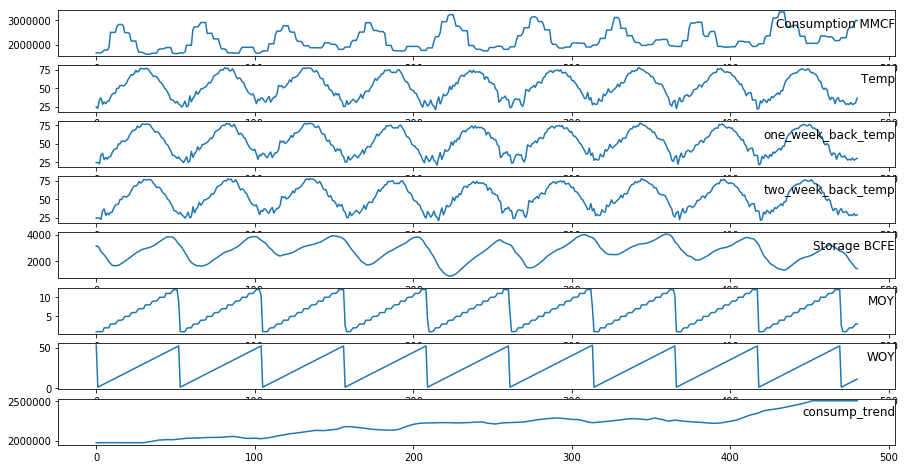

In [276]:
values = clean_df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8]
i = 1
# plot each column
pyplot.figure(figsize=(15, 8))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(clean_df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [195]:
 # convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -52):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [277]:

values = clean_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 52, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.head(10))
 


    var1(t-52)  var2(t-52)  var3(t-52)  var4(t-52)  var5(t-52)  var6(t-52)  \
52    0.029086    0.062376    0.062376    0.062376    0.114548    0.711548   
53    0.029086    0.029358    0.062376    0.062376    0.114548    0.711548   
54    0.029086    0.235783    0.029358    0.062376    0.114548    0.664168   
55    0.029086    0.280119    0.235783    0.029358    0.114548    0.585511   
56    0.056841    0.127864    0.280119    0.235783    0.097126    0.537909   
57    0.093848    0.181843    0.127864    0.280119    0.073896    0.506056   
58    0.093848    0.139937    0.181843    0.127864    0.073896    0.456679   
59    0.093848    0.198004    0.139937    0.181843    0.073896    0.397764   
60    0.154234    0.200051    0.198004    0.139937    0.079612    0.342043   
61    0.516552    0.293840    0.200051    0.198004    0.113910    0.298611   

    var7(t-52)  var8(t-52)  var9(t-52)   var1(t)  
52    0.000000    1.000000    0.000236  0.021204  
53    0.000000    0.000000    0.000236 

In [278]:
len(values), len(clean_df)

(481, 481)

In [279]:
# split into train and test sets
values = reframed.values
n_train_weeks = int(len(values) * 0.75)

train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 


(321, 1, 9) (321,) (108, 1, 9) (108,)


In [280]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 321 samples, validate on 108 samples
Epoch 1/50
 - 2s - loss: 0.3758 - val_loss: 0.4588
Epoch 2/50
 - 0s - loss: 0.3050 - val_loss: 0.3784
Epoch 3/50
 - 0s - loss: 0.2453 - val_loss: 0.3047
Epoch 4/50
 - 0s - loss: 0.2158 - val_loss: 0.2620
Epoch 5/50
 - 0s - loss: 0.2095 - val_loss: 0.2449
Epoch 6/50
 - 0s - loss: 0.2082 - val_loss: 0.2371
Epoch 7/50
 - 0s - loss: 0.2049 - val_loss: 0.2316
Epoch 8/50
 - 0s - loss: 0.1993 - val_loss: 0.2284
Epoch 9/50
 - 0s - loss: 0.1924 - val_loss: 0.2275
Epoch 10/50
 - 0s - loss: 0.1860 - val_loss: 0.2282
Epoch 11/50
 - 0s - loss: 0.1809 - val_loss: 0.2271
Epoch 12/50
 - 0s - loss: 0.1760 - val_loss: 0.2238
Epoch 13/50
 - 0s - loss: 0.1713 - val_loss: 0.2187
Epoch 14/50
 - 0s - loss: 0.1665 - val_loss: 0.2125
Epoch 15/50
 - 0s - loss: 0.1618 - val_loss: 0.2061
Epoch 16/50
 - 0s - loss: 0.1572 - val_loss: 0.2000
Epoch 17/50
 - 0s - loss: 0.1524 - val_loss: 0.1944
Epoch 18/50
 - 0s - loss: 0.1477 - val_loss: 0.1902
Epoch 19/50
 - 0s - loss: 0

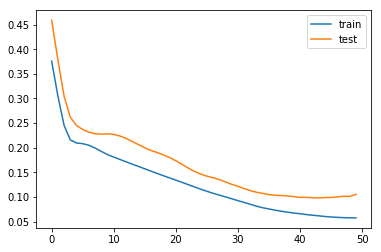

In [281]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 


In [282]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [283]:
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 48390807552.000


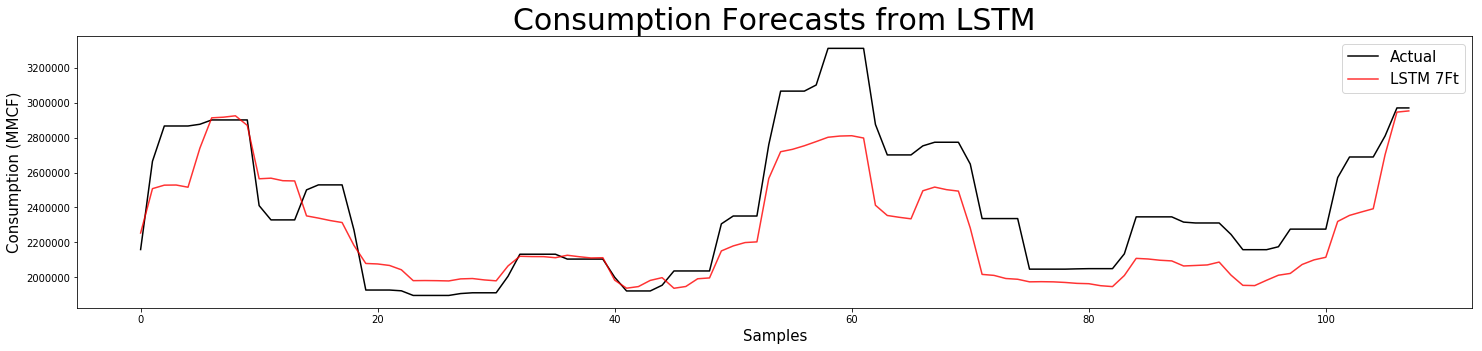

In [284]:
fig, axs = pyplot.subplots(figsize=(25, 5))
axs.plot(inv_y, color='black', label = 'Actual')
axs.plot(inv_yhat, color='red', alpha = 0.8, label = 'LSTM 7Ft')
axs.set_title("Consumption Forecasts from LSTM", fontsize = 30)
axs.set_ylabel("Consumption (MMCF)", fontsize = 15)
axs.set_xlabel("Samples", fontsize = 15)
axs.legend(fontsize = 15)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
pyplot.show()